## WCF Modelling

This code:

- Import a CSV and create a random forest model
- Choose a location and download some satellite data
- Apply model to satellite image
- Do some plotting

#### Questions and things to do

- Why is the data in the geomedian orders larger than the data in the csv?
    - I think the geomedian is in DNs and the training data is SR?
- What is the threshold for woody / not woody?
    - If it measures how woody, everything over 0 is woody?
- Fiddle with the random forest parameters
- Should I transform the inputs to be gaussian?

#### Other things to consider

- WCF saturates above 0.6

#### Sources of error

- Since WCF is derived from single-date LiDAR data and an annual geomedian is being used to predict it the geomedian may not represent the same vegetation as was present when LiDAR was acquired.
- Mixed pixels containing water and vegetation tended to overestimate WCF.
- Vegetation lower than 2m (e.g. dense shrubland or new plantations) could have a WCF from Landsat, although LiDAR would not have.

LiDAR
- Variation in pulse density (4 to 8 ppm)
- Variation in achieved density returns (4 to 20 ppm)

WCF derived from LiDAR was suprisingly low
- possibly due to attribution of VCF to height, and only above 2m is considered in WCF
- identifying points in LiDAR waveform is more challenging over dense uniform forest

Overall systematic underestimation of true cover at high values



#### Import modules

In [1]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV

In [2]:
dc = datacube.Datacube(app='Alberts Forest')

#### Import training data csv

In [3]:
path = 'WCF_traindata_22102019.csv'
df = pd.read_csv(path)
df.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.261320,0.034313,0.047605,0.052131,0.19575,0.14400,0.082638
1,0.116210,0.044998,0.067579,0.083996,0.20979,0.25615,0.160270
2,0.408240,0.022349,0.035390,0.040748,0.19127,0.11858,0.070578
3,0.000000,0.048717,0.077072,0.091846,0.24272,0.29843,0.190590
4,0.053365,0.059975,0.087660,0.104420,0.23314,0.27891,0.184080


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.4300e+02, 2.9910e+03, 1.0091e+04, 4.6360e+03, 3.0950e+03,
        3.3790e+03, 2.5860e+03, 2.6170e+03, 2.3170e+03, 2.2930e+03,
        1.8350e+03, 1.6390e+03, 1.5450e+03, 9.6700e+02, 3.0900e+02,
        1.2600e+02, 8.6000e+01, 7.3000e+01, 4.7000e+01, 5.5000e+01,
        4.0000e+01, 3.0000e+01, 3.1000e+01, 1.8000e+01, 1.1000e+01,
        1.9000e+01, 1.2000e+01, 4.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([-0.0017486 ,  0.01440769,  0.03056397,  0.04672026,  0.06287655,
         0.07903283,  0.09518912,  0.11134541,  0.12750169,  0.14365798,
         0.15981427,  0.17597055,  0.19212684,  0.20828313,  0.22443941,
         0.2405957 ,  0.25675199,  0.27290827,  0.28906456,  0.30522085,
         0.32137713,  0.33753342,  0.35368971,  0.36984599,  0.38600228,
         0.40215857,  0.41831485,  0.43447114,  0.45062743,  0.46678371,
         0.48294   ]),
 <a list of 30 Patch objects>)

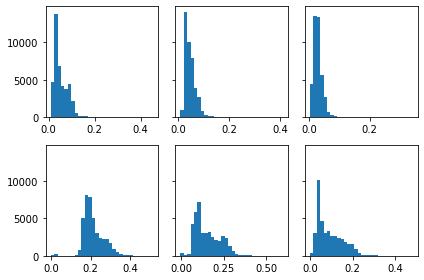

In [4]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].hist(df[' red'],bins=30)
axs[0,1].hist(df[' green'],bins=30)
axs[0,2].hist(df['blue'],bins=30)
axs[1,0].hist(df[' nir'],bins=30)
axs[1,1].hist(df[' swir1'],bins=30)
axs[1,2].hist(df[' swir2'],bins=30)

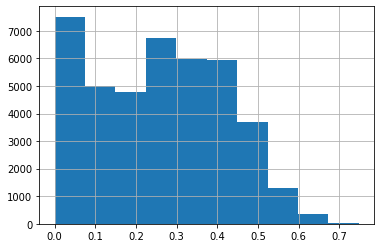

In [5]:
# Plot a histogram of WCF values
df['WCF'].hist()

#### Create and evaluate model

https://www.youtube.com/watch?v=YYjvkSJoui4 

In [40]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# Define model
model = RandomForestRegressor(n_estimators=100, # number of trees in forest, is this equal to ensemble?
                              #criterion = 'mse', # function to measure the quality of the split
                              #max_depth = None, # max depth of tree. If None, then nodes are expanded until all laves are pure, or until all leaves contain less than min_samples_split
                              #min_samples_split = 30, # Min no. samples required to be at a split node 
                              min_samples_leaf = 50, # Min no. samples required to be at a leaf node 
                              #min_weight_fraction_leaf = 0, # The min weighted fraction. Samples have equal weight when 0.
                              #max_features = 'auto', # The number of features to consider when looking for the best split
                              #max_leaf_nodes = None, # If None, then unlimited number of leaf nodes
                              #min_impurity_decrease = 0, # Split nodes to decrease impurity
                              #min_impurity_split = 1e-7, # Replaced by min_impurity_decrease
                              #bootstrap = true, # Whether to bootstrap samples when building trees. If False, the whole dataset is used ot build each tree.
                              #oob_score = False, # Whether to use out-of-bag samples to estimate R^2 on unseen data
                              #n_jobs = None, # The number of jobs to run in parallel. None means 1
                              random_state=30, # Controls the randomness of bootstrapping and the sampling of features to consider for bets node split
                              #verbose = 0, # Controls the verbosity when fititng and predicting
                              #warm_start = False, # False - fit new forest, True - reuse solution from previous call amd add more estimators to ensemble
                              #ccp_alpha = 0.0, # Complexity parameter
                              #max_samples = None, # If bootstrap is True, the numbe rof samples to draw from X to train each base estimator
                             )

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

In [41]:
X_train.head()

,blue,green,red,nir,swir1,swir2
19134,0.033285,0.055250,0.080734,0.19052,0.20046,0.144430
31581,0.007428,0.025892,0.029882,0.19237,0.08904,0.040041
22772,0.034568,0.054711,0.062599,0.20995,0.18049,0.112290
25767,0.026890,0.041377,0.029134,0.32917,0.11834,0.046095
9749,0.035851,0.054980,0.067171,0.18974,0.22409,0.134130


In [42]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

#### Performance metrics

In draft:
- Root mean square estimate (RMSE) = 0.061
- Coefficient of determination (R^2) = 0.862
- Nash-Sutcliffe model efficiency (ME) = 0.862

In [45]:
# Metrics
print('Explained variance score = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html
print('R^2 =')
print(metrics.r2_score(Y_test, prediction_test))
print('RMSE =')
print(metrics.mean_squared_error(Y_test, prediction_test))

Explained variance score = 
0.8492327927931287
R^2 =
0.8492093019788143
RMSE =
0.003991322713870253


In [46]:
Y_test

21884    0.22498
36839    0.37884
34066    0.31363
34359    0.29547
37144    0.30360
          ...   
27092    0.48518
26112    0.32235
11671    0.39974
36657    0.45676
33402    0.26588
Name: WCF, Length: 8241, dtype: float64

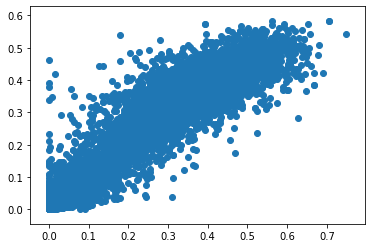

In [12]:
plt.scatter(Y_test, prediction_test)

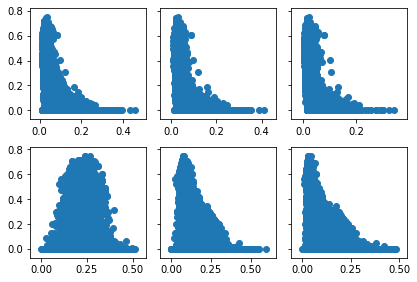

In [13]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].scatter(df[' red'],df['WCF'])
axs[0,1].scatter(df[' green'],df['WCF'])
axs[0,2].scatter(df['blue'],df['WCF'])
axs[1,0].scatter(df[' nir'],df['WCF'])
axs[1,1].scatter(df[' swir1'],df['WCF'])
axs[1,2].scatter(df[' swir2'],df['WCF'])

#### Order of importance



nir, blue, swir1, green, swir2, red

In [14]:
# Determine the importance of each of the bands
#print(model.feature_importances_) # need to format nicely
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

 red      0.592814
 nir      0.110904
 swir1    0.090928
 swir2    0.084813
 green    0.081431
blue      0.039109
dtype: float64


## Hyperparameter tuning with:
1. Randomized Search CV
2. Grid Search CV

In [15]:
# Create a blank model
model_cv = RandomForestRegressor(n_jobs=-1, verbose=0)

# View the hyperparameters
print(model_cv.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


## Explore parameter tuning with Randomized Search CV

#### Set up the grid for use in the randomised search

In [ ]:
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# max_leaf_nodes = [20, 25, 30, 35, 40]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

Variables to use in the grid:

In [56]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 300, num = 20)]

# Minimum number of samples required at each leaf
min_samples_leaf = [1, 10, 30, 50, 75, 100]

# Random state
random_state = [None, 0, 10, 20, 30]

Create the grid:

In [57]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [40, 53, 67, 81, 94, 108, 122, 135, 149, 163, 176, 190, 204, 217, 231, 245, 258, 272, 286, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 10, 30, 50, 75, 100], 'bootstrap': [True, False]}


#### Run the randomised search

This may take a while... 
(20 takes about 8 minutes)

In [58]:
rscv_model = RandomizedSearchCV(estimator = model_cv, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rscv_results = rscv_model.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.5min finished


#### See the relative importance of variables

In [36]:
model_variables = ['blue', ' green', ' red', ' nir', ' swir1', ' swir2']

# Variable importance
for var_name, var_importance in zip(model_variables, rscv_results.best_estimator_.feature_importances_):
    print("{}: {:.04}".format(var_name, var_importance))

blue: 0.04542
 green: 0.08816
 red: 0.5814
 nir: 0.1128
 swir1: 0.09404
 swir2: 0.07819


#### From the randomised search find the best parameter values to use

In [38]:
# Print best parameter values
rscv_results.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=28, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=163, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Create an improved model using the best parameter values
Copy best_estimator_ parameters into the code below

In [53]:
# Create an instance of the model
improved_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=28, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=163, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Fit the model
improved_model.fit(X_train,Y_train)

# Predict Y from X_test
pt = improved_model.predict(X_test)

# Print the R2
metrics.r2_score(Y_test,pt)

0.8760712185020482

## Detailed parameter tuning with Grid Search CV

#### Set up the grid for use in the grid search

In [68]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_leaf': [1, 30, 60],
    'random_state':[None,0,30]
}

#### Run the grid search

This may take a while... 
(37 tasks takes about 5.5 minutes)

In [69]:
grid_model = GridSearchCV(estimator = model_cv, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)
grid_results = grid_model.fit(X_train, Y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 10.3min finished


#### From the randomised search find the best parameter values to use

In [70]:
print(grid_results.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)


#### Create an improved model using the best parameter values
Copy best_estimator_ parameters into the code below

In [71]:
# Create an instance of the model
improved_grid_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)

# Fit the model
improved_grid_model.fit(X_train,Y_train)

# Predict Y from X_test
grid_pt = improved_grid_model.predict(X_test)

# Print the R2
metrics.r2_score(Y_test,grid_pt)

0.8789292728182699

## Choose location

When models were made for individual locations the performance varied significantly.

- Whroo in Victoria have an R^2 of only 0.35 (-36.703137, 145.035462)
- ACT had an R^2 of 0.87 (-35.434967, 149.002428)

How to make this work as an area:

In [72]:
# Ayr
x = (1500000, 1600000)
y = (-2200000, -2100000)
min_x = 1500000
max_x = 1600000
min_y = -2200000
max_y = -2100000
res_x = 100
res_y = -100

In [74]:
# Set the central latitude and longitude
central_lat = -35.434967
central_lon = 149.002428

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [75]:
start_date = '2009'
end_date = '2009' 

#Load all data in baseline period available from Near Real Time data

baseline_da = dc.load(
              product='ls5_nbart_geomedian_annual',# ls5_nbart_geomedian_annual, ls8_nbart_geomedian_annual
              x=study_area_lon,
              y=study_area_lat,
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              #group_by='solar_day'
)
baseline_da

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [ ]:
print(baseline_da.min())
print(baseline_da.max())
print(df.min())
print(df.max())

#### Prepare dataset to go in model

In [ ]:
flat = sklearn_flatten(baseline_da)
flat

In [ ]:
#normal = preprocessing.normalize(flat)
#normal = (flat-flat.mean())/(flat.max()-flat.min())
normal = flat/10000
print(flat.min())
print(flat.max())
print(normal.min())
print(normal.max())
normal

#### Run model

In [ ]:
results = model.predict(normal)
results

#### Unflatten results

In [ ]:
unflat = (sklearn_unflatten(results,baseline_da).transpose())[0]
unflat

In [ ]:
max(results)

#### Plot some results

In [ ]:
# Woody cover in training data varies between 0 and 0.75
unflat.plot(figsize=(10,10),vmin=0,vmax=0.5)

In [ ]:
xr.plot.hist(unflat,bins=100,range=(0,0.05))

#### Apply a threshold

In [ ]:
not_woody = unflat<=0.1
woody = np.logical_and(unflat>0.1,unflat<=0.2)
very_woody = unflat>0.2

#We use this numpy function to stack 2-dimensional arrays over the 3rd axis or depth:
classes= np.dstack((not_woody,very_woody,woody)).astype(np.uint8) * 255

plt.imshow(classes)

In [ ]:
# Constants for calculating burnt area
resolution = (-30,30)
pixel_length = resolution[1] # in metres
#print(pixel_length)
m_per_km = 1000 # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length**2/m_per_km**2
#print(area_per_pixel)

# Calculate areas
not_woody_area = np.sum(not_woody.values)*area_per_pixel
woody_area = np.sum(woody.values)*area_per_pixel
very_woody_area = np.sum(very_woody.values)*area_per_pixel

print('Not woody:  ',not_woody_area)
print('Woody:      ',woody_area)
print('Very woody: ',very_woody_area)

In [ ]:
# Mask
masked = baseline_da.where(unflat>0.1)
rgb(masked, bands=['red', 'green', 'blue'],size=10)

In [ ]:
# Visualise median image as true colour image
rgb(baseline_da, bands=['red', 'green', 'blue'],size=10)